# ATP Tennis Data - Player Diff Stats + One Hot Encoding (All Categorical Data) + Player History


In our previous [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/5.2-atp_diff-ohe.ipynb), we did not see any improvement from encoding more categorical columns in our model. In fact we saw as slight decrease in our precision for predicting losses

In this notebook, we will run the same algorithms but we will add historical data from player 1 and 2. Historical data was created in this [notebook](https://github.com/sv650s/sb-capstone2/blob/master/notebooks/6-apt_advanced_feature_engineering-history.ipynb) where we aggregated match data for each player for the most recent 5 matches leading up to each match

Data that we obtained for each player:

* wins - matches won
* losses - matches lost
* games won
* sets won
* games lost
* sets lost
* winning percentage = wins / (wins + losses)
* games won percetnage = games won / (games won + games lost)
* sets won percentage = sets won / (sets won + sets lost)

We will see if this data helps improve our models

### Results from Decision Tree Classifier with player diff + one hot encoded categorial features:

```
Model Score: 0.9307224848075625

              precision    recall  f1-score   support

        Loss       0.93      0.94      0.93      7416
         Win       0.93      0.93      0.93      7394

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```

# Summary of Results

Decision Tree is still performing slightly below our model when we do not use matchup data. Although, using diff matchup data seems to perform the best out of all matchup data.

```
Model Score: 0.925455773126266

              precision    recall  f1-score   support

        Loss       0.92      0.93      0.93      7453
         Win       0.93      0.92      0.92      7357

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810
```




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from datetime import datetime
import pickle
import json
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from util import jupyter_util as ju
from util.model_util import ModelWrapper, REPORT_FILE, RSTATE, N_JOBS, MAX_ITER, LABEL_COL

%matplotlib inline
sns.set()


# date
DATE_FORMAT = '%Y-%m-%d'
DATE = datetime.now().strftime(DATE_FORMAT)

DESCRIPTION = "diff-ohe-matchup_diff"


# update this
FEATURE_FILE = f'../datasets/atp_matches_1985-2019_features-diff-ohe-history5-matchup5.csv'

START_YEAR = 1998
END_YEAR = 2018




In [2]:
X_train, X_test, y_train, y_test = ju.get_data(FEATURE_FILE, LABEL_COL, START_YEAR, END_YEAR)

Our dataset actually has both historical data as well as matchup data. We will remove the matchup columns from the dataset

In [3]:
import re

def filter_features(data: pd.DataFrame):
    history_columns = [col for col in data.columns if re.search('history', col)]
    print(f'Before: data.shape {data.shape}')
    data = data.drop(history_columns, axis=1)

    # drop all columns that doesn't have diff
    matchup_columns = [col for col in data.columns if re.search('matchup', col) and not re.search('diff', col)]
    data = data.drop(matchup_columns, axis=1)

    print(f'After: data.shape {data.shape}')
    
    return data
    
X_train = filter_features(X_train)
X_test = filter_features(X_test)

Before: data.shape (44429, 5293)
After: data.shape (44429, 5254)
Before: data.shape (14810, 5293)
After: data.shape (14810, 5254)


In [4]:
[col for col in X_train.columns if re.search('matchup', col)]

['p1_matchup_games_diff', 'p1_matchup_sets_diff', 'p1_matchup_wins_diff']

# Logistic Regression

In [5]:

# train our model

lr = ModelWrapper(LogisticRegression(n_jobs = N_JOBS, verbose = 1, random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_lr = lr.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

Model Score: 0.6726536124240378

ROC/AUC Score: 0.6727195194183309
              precision    recall  f1-score   support

        Loss       0.68      0.66      0.67      7453
         Win       0.67      0.68      0.67      7357

    accuracy                           0.67     14810
   macro avg       0.67      0.67      0.67     14810
weighted avg       0.67      0.67      0.67     14810

      Loss   Win
Loss  4938  2515
Win   2333  5024


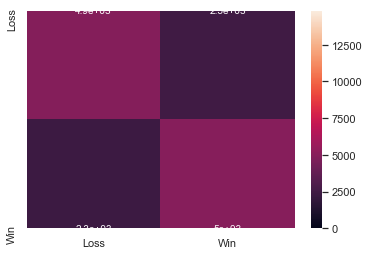

In [6]:
lr.analyze()

In [7]:
# ju.plot_2d(X_test, y_predict_lr)

In [8]:
lr.save()

Saving report: ../reports/summary.csv


# KNN

In [9]:

# train our model

knn = ModelWrapper(KNeighborsClassifier(n_jobs = N_JOBS),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_knn = knn.predict()

Model Score: 0.8331532748143147

ROC/AUC Score: 0.8330644135718447
              precision    recall  f1-score   support

        Loss       0.83      0.85      0.84      7453
         Win       0.84      0.82      0.83      7357

    accuracy                           0.83     14810
   macro avg       0.83      0.83      0.83     14810
weighted avg       0.83      0.83      0.83     14810

      Loss   Win
Loss  6311  1142
Win   1329  6028


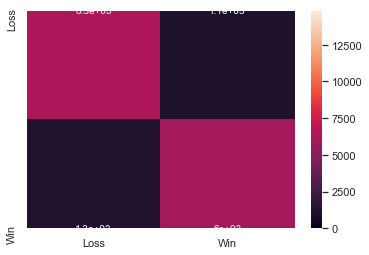

In [10]:
knn.analyze()

In [11]:
# ju.plot_2d(X_test, y_predict_knn)

In [12]:
knn.save()

Saving report: ../reports/summary.csv


# Decision Tree

In [13]:

# train our model

dt = ModelWrapper(DecisionTreeClassifier(random_state = RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_dt = dt.predict()

Model Score: 0.925455773126266

ROC/AUC Score: 0.9254342572978876
              precision    recall  f1-score   support

        Loss       0.92      0.93      0.93      7453
         Win       0.93      0.92      0.92      7357

    accuracy                           0.93     14810
   macro avg       0.93      0.93      0.93     14810
weighted avg       0.93      0.93      0.93     14810

      Loss   Win
Loss  6922   531
Win    573  6784


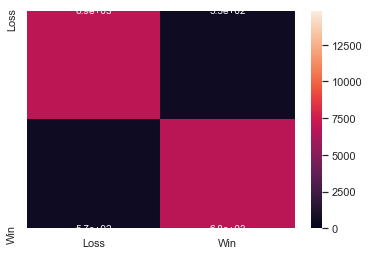

In [14]:
dt.analyze()

In [15]:
# ju.plot_2d(X_test, y_predict_dt)

In [16]:
dt.save()

Saving report: ../reports/summary.csv


# Random Forest Classifier

In [17]:

# train our model

rf = ModelWrapper(RandomForestClassifier(random_state=RSTATE, verbose=1),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_rf = rf.predict()

//anaconda3/envs/capstone2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


Model Score: 0.7916948008102633

ROC/AUC Score: 0.7914641325958016
              precision    recall  f1-score   support

        Loss       0.77      0.83      0.80      7453
         Win       0.81      0.76      0.78      7357

    accuracy                           0.79     14810
   macro avg       0.79      0.79      0.79     14810
weighted avg       0.79      0.79      0.79     14810

      Loss   Win
Loss  6164  1289
Win   1796  5561


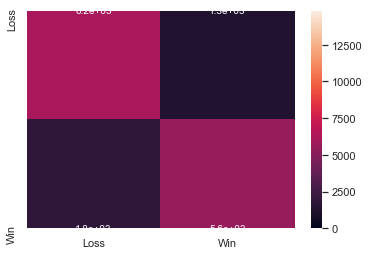

In [18]:
rf.analyze()

In [19]:
# ju.plot_2d(X_test, y_predict_rf)

In [20]:
rf.save()

Saving report: ../reports/summary.csv


# Gradient Boosting

In [21]:

# train our model

gb = ModelWrapper(GradientBoostingClassifier(random_state=RSTATE, verbose=1, n_iter_no_change = 4),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_gb = gb.predict()

      Iter       Train Loss   Remaining Time 
         1           1.3157            9.98m
         2           1.2579           10.01m
         3           1.2102            9.68m
         4           1.1722            9.69m
         5           1.1405            9.67m
         6           1.1058            9.88m
         7           1.0785            9.98m
         8           1.0558            9.89m
         9           1.0321            9.78m
        10           1.0159            9.63m
        20           0.8899            8.45m
        30           0.8228            7.43m
        40           0.7862            6.49m
        50           0.7597            5.49m
        60           0.7419            4.35m
        70           0.7282            3.19m
        80           0.7122            2.10m
        90           0.6910            1.04m
       100           0.6864            0.00s


Model Score: 0.8522619851451722

ROC/AUC Score: 0.8521227156083612
              precision    recall  f1-score   support

        Loss       0.84      0.87      0.86      7453
         Win       0.87      0.83      0.85      7357

    accuracy                           0.85     14810
   macro avg       0.85      0.85      0.85     14810
weighted avg       0.85      0.85      0.85     14810

      Loss   Win
Loss  6511   942
Win   1246  6111


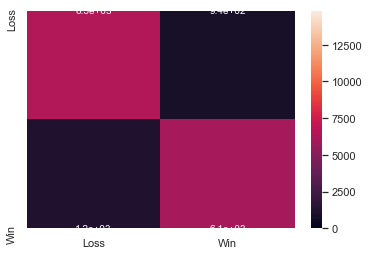

In [22]:
gb.analyze()

In [23]:
# ju.plot_2d(X_test, y_predict_gb)

In [24]:
gb.save()

Saving report: ../reports/summary.csv


# AdaBoost

In [25]:
ab = ModelWrapper(AdaBoostClassifier(random_state=RSTATE),
                  description = DESCRIPTION, 
                 data_file = FEATURE_FILE,
                  start_year = START_YEAR,
                  end_year = END_YEAR,
                   X_train = X_train,
                   y_train = y_train,
                   X_test = X_test,
                   y_test = y_test).fit()
y_predict_ab = ab.predict()

Model Score: 0.7492910195813639

ROC/AUC Score: 0.7490611957994169
              precision    recall  f1-score   support

        Loss       0.74      0.78      0.76      7453
         Win       0.77      0.71      0.74      7357

    accuracy                           0.75     14810
   macro avg       0.75      0.75      0.75     14810
weighted avg       0.75      0.75      0.75     14810

      Loss   Win
Loss  5847  1606
Win   2107  5250


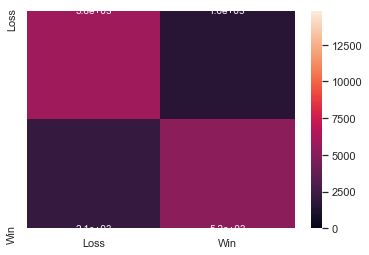

In [26]:
ab.analyze()

In [27]:
# ju.plot_2d(X_test, y_predict_ab)

In [28]:
ab.save()

Saving report: ../reports/summary.csv


# Results

* Decision Tress is still our best model, although adding this data decreased our performance to be about 1% (back to diff+ohe_player performance)
* No change in performance for Ada Boost or Logistic regression or Gradient Boost
* Around 5% decrease in accuracy for KNN and Random Forest

In [29]:
report = pd.read_csv(REPORT_FILE)
report.tail(5)

,model_name,description,data_file,start_year,end_year,accuracy,roc_auc_score,confusion_matrix,classification_report,model_file,predict_time_min,fit_time_min,total_time_min
67,KNeighborsClassifier,diff-ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.833153,0.833064,"{""0"": {""0"": 6311, ""1"": 1329}, ""1"": {""0"": 1142,...","{""Loss"": {""precision"": 0.8260471204188482, ""re...",../models/kneighborsclassifier-1998-2018-diff-...,0.0,0.0,0.0
68,DecisionTreeClassifier,diff-ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.925456,0.925434,"{""0"": {""0"": 6922, ""1"": 573}, ""1"": {""0"": 531, ""...","{""Loss"": {""precision"": 0.923549032688459, ""rec...",../models/decisiontreeclassifier-1998-2018-dif...,0.0,0.0,0.0
69,RandomForestClassifier,diff-ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.791695,0.791464,"{""0"": {""0"": 6164, ""1"": 1796}, ""1"": {""0"": 1289,...","{""Loss"": {""precision"": 0.7743718592964824, ""re...",../models/randomforestclassifier-1998-2018-dif...,0.0,0.0,0.0
70,GradientBoostingClassifier,diff-ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.852262,0.852123,"{""0"": {""0"": 6511, ""1"": 1246}, ""1"": {""0"": 942, ...","{""Loss"": {""precision"": 0.8393708908083022, ""re...",../models/gradientboostingclassifier-1998-2018...,0.0,10.0,10.0
71,AdaBoostClassifier,diff-ohe-matchup_diff,../datasets/atp_matches_1985-2019_features-dif...,1998,2018,0.749291,0.749061,"{""0"": {""0"": 5847, ""1"": 2107}, ""1"": {""0"": 1606,...","{""Loss"": {""precision"": 0.735101835554438, ""rec...",../models/adaboostclassifier-1998-2018-diff-oh...,0.0,1.0,1.0


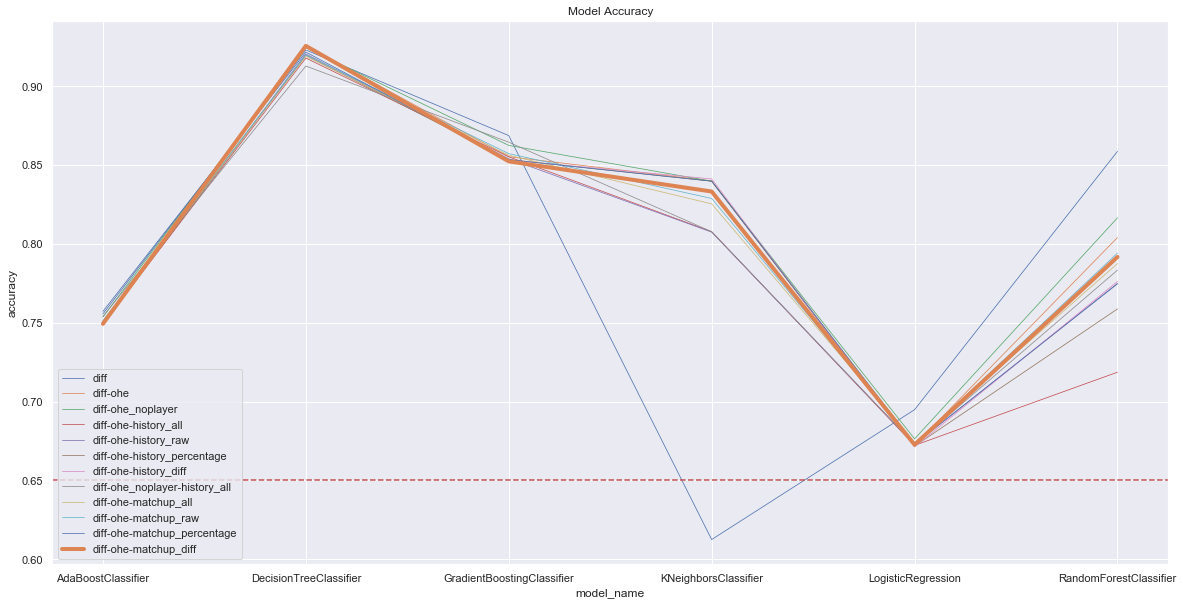

In [30]:
f, a = plt.subplots(1, 1, figsize=(20, 10))

descs = report.description.unique()

for desc in descs:
    report_desc = report[report.description == desc]
    if desc == DESCRIPTION:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=4)
    else:
        sns.lineplot(x="model_name", y="accuracy", data=report_desc, label=desc, linewidth=0.75)

a.axhline(0.65, ls='--', color='r')
a.set_title(f"Model Accuracy")
_ = a.legend(loc="lower left")

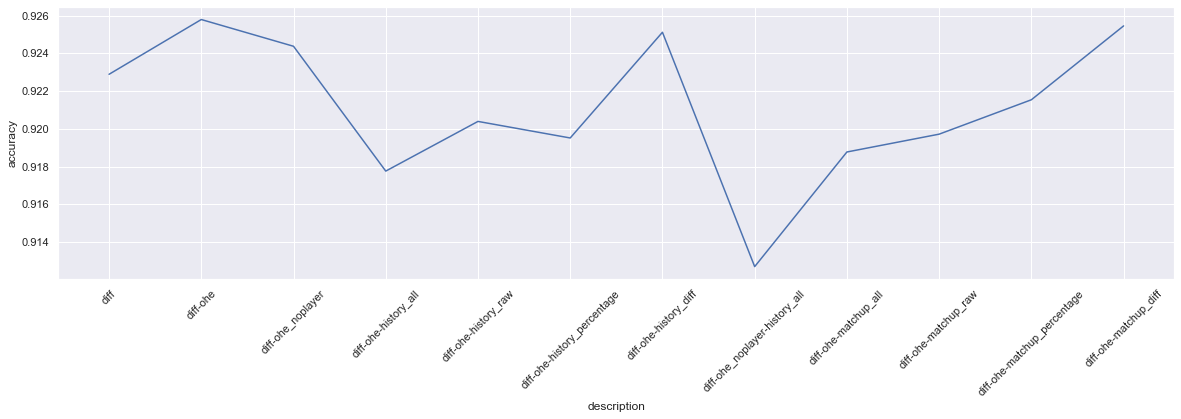

In [31]:
dt_report = report[(report.model_name == 'DecisionTreeClassifier')]

f, a = plt.subplots(1, 1, figsize=(20, 5))
_ = sns.lineplot(x="description", y="accuracy", data=dt_report, ax=a, sort=False)
_ = a.set_label("Decision Tree Classifier Accuracy")
_ = plt.xticks(rotation=45)


In [32]:
import shap

shap.initjs()

mw = ModelWrapper.get_model_wrapper_from_report(dt_report[dt_report.description == DESCRIPTION])


explainer = shap.TreeExplainer(mw.model, data=X_train.values)
shap_values = explainer.shap_values(X_test.values)
print(np.array(shap_values).shape)



(2, 14810, 5254)


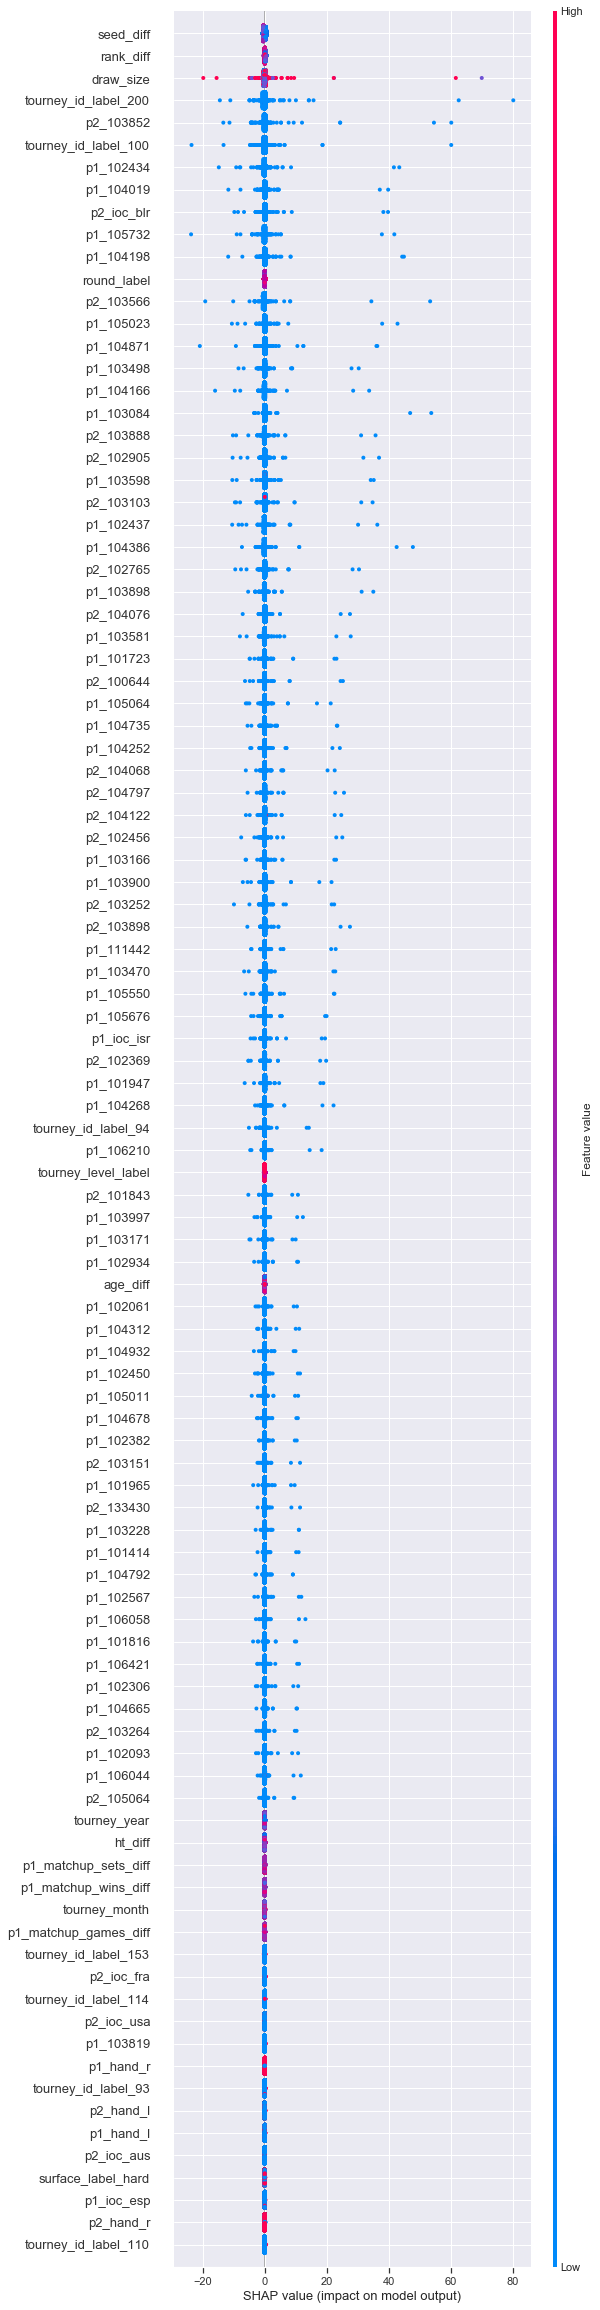

In [33]:
shap.summary_plot(shap_values[1], X_test, feature_names=X_test.columns, max_display=100)

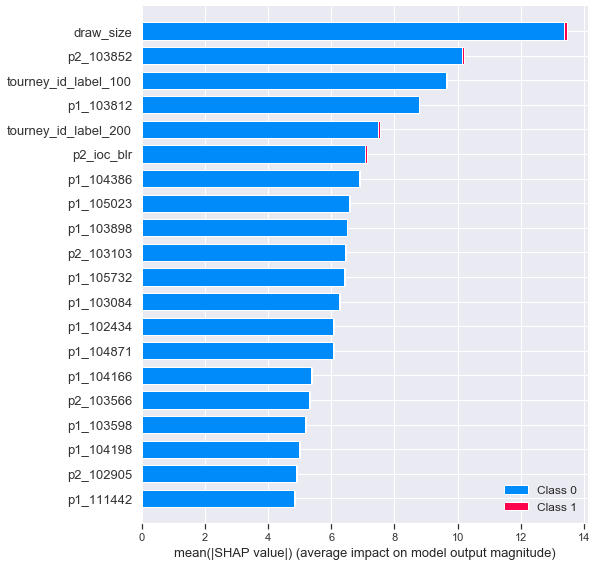

In [34]:
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, title="Feature Importance")

In [35]:
import util
import util.mapping_util as mu

import importlib
importlib.reload(util.mapping_util)

import logging
logging.basicConfig(level=logging.INFO)

mu.Mapper.get_player_info_by_id('p2_103852')

INFO:util.mapping_util:player_id: ['103852']


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2503 entries, 0 to 2502
Data columns (total 12 columns):
id              2503 non-null object
name            2503 non-null object
ht              1654 non-null float64
hand            2503 non-null object
ioc             2503 non-null object
wins            2503 non-null int64
losses          2503 non-null int64
matches         2503 non-null int64
pro_date        2503 non-null object
retire_date     2503 non-null object
years_as_pro    2503 non-null int64
birthday        2503 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 234.8+ KB


,id,name,ht,hand,ioc,wins,losses,matches,pro_date,retire_date,years_as_pro,birthday
688,103852,feliciano lopez,188.0,L,ESP,472,424,896,1998-04-13,2019-02-25,21,1981-09-28
